In [3]:
import networkx as nx
import preprocessing as prep
import numpy as np
import pandas as pd
import numpy as np
import json
import os
import datetime
import pytz
import matplotlib.pyplot as plt
from collections import Counter
from bb_binary import load_frame_container, Repository
from pandas import Series, DataFrame
import seaborn as sns
import igraph as ig
import sqlite3
import hatching as ht
from scipy import stats

%matplotlib inline

In [5]:
graph_files = os.listdir()
graph_files = [g for g in graph_files if g.endswith('.graphml')]

In [6]:
graph_files

['1-20150821000000allCams_0.99conf_160dist_6ilen.graphml',
 '08month-160dist-09conf-3len.graphml',
 '09month-160dist-09conf-3len.graphml',
 'TT2_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-17 08:00:00+00:00.graphml',
 'test2016_0.99conf_160dist_3ilen.graphml',
 '1day20150822_0.95conf_160dist_3ilen.graphml',
 '10month-160dist-09conf-3len.graphml',
 '08month-160dist-09conf-3len-1h.graphml',
 '1h-allCams_0.99conf_160dist_6ilen.graphml',
 '1day20150822_0.95conf_160dist_3ilen_filtered.graphml',
 '10month-160dist-09conf-3len-1h.graphml',
 '1day20150822_0.95conf_160dist_4ilen.graphml',
 'TT2_10h_95conf_212dist_4ilen_2gap_600minutes_2016-08-17 08:00:00+00:00.graphml',
 '10month-320dist-09conf-3len.graphml',
 '08month-320dist-09conf-3len.graphml',
 'TT3_10h_95conf_212dist_4ilen_2gap_600minutes_2016-08-20 08:00:00+00:00.graphml',
 'test2016_0.99conf_160dist_6ilen.graphml',
 '1day20150822_0.95conf_160dist_5ilen.graphml',
 '09month-160dist-09conf-3len-1h.graphml',
 'TT1_10h_95conf_212dist_4il

In [7]:
f = 'networks/0820_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-20_08:00:00+00:00.graphml'

In [8]:
G = nx.read_graphml(f)

In [9]:
start = "2016-08-20"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%d").replace(tzinfo=pytz.UTC)

In [10]:
def plotDegreeDistribution(G, w):
    degrees = G.degree(weight=w).values()
    Series(list(degrees)).hist(bins=25)
    plt.figure()
    Series(list(degrees)).plot.box()
    print(Series(list(degrees)).describe())

In [11]:
def addAge(df, date_dt):
    aa = ht.get_all_bees_age(date_dt)
    df["age"] = df.id.apply(lambda x: aa.iloc[x].age)
    return df

In [12]:
def getNodesAndAges(g, date_dt, colid, colage):
    aa = ht.get_all_bees_age(date_dt)
    df = DataFrame([int(x) for x in list(g.nodes())], columns=[colid])
    df[colage] = df.id.apply(lambda x: aa.iloc[x].age)
    return df

# Network Analysis - One hour Network
* 12:00:00 Uhr, 60 Minutes, 26.07.2016
* Confidence: 0.95
* Maximum Distance: 212px (average length of a bee)
* Minimum Contact Duration: 3 frames
* Gap size: 2
* Computation Time: 4min50s (8 CPUs)
* File Size: 11MB

## Global Properties

### Number of nodes and edges, average unweighted degree and density, diameter

In [13]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 922
Number of edges: 291179
Average degree: 631.6247


In [14]:
density = nx.density(G)
print('Density: {}'.format(density))

Density: 0.6858031800763577


In [184]:
diameter = nx.diameter(G)
print("Diameter: {}".format(diameter))

Diameter: 3


### Age Distribution (without queen)

In [185]:
ages = getNodesAndAges(G,start_dt, 'id', 'age')
print("{} of {} nodes with negative age".format(len(ages[ages.age < 0]), ages.shape[0]))

12 of 1193 nodes with negative age


In [186]:
print("{} with negative age = -100 (id not assignes at all)".format(len(ages[ages.age == -100])))

11 with negative age = -100 (id not assignes at all)


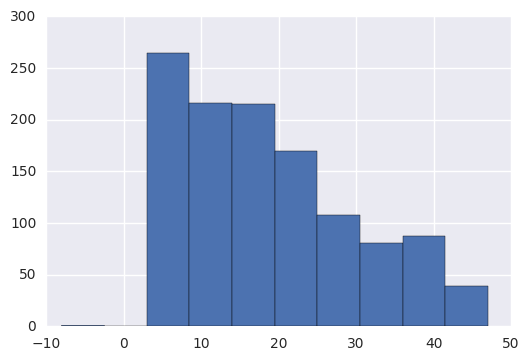

In [189]:
ages = ages.query('age > -100 & age <200')
ages.age.hist(bins=10)

### Nodes

#### Unweighted Degree Distribution

count    1193.000000
mean      680.675608
std       185.894855
min         1.000000
25%       597.000000
50%       713.000000
75%       804.000000
max      1034.000000
dtype: float64


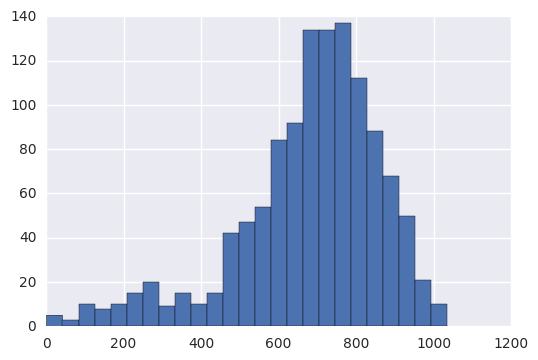

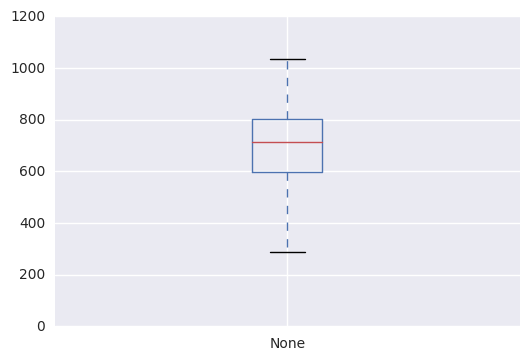

In [190]:
plotDegreeDistribution(G, None)

#### Weighted Degree Distribution

count     1193.000000
mean      5741.812238
std       3040.943080
min          1.000000
25%       3536.000000
50%       5516.000000
75%       7681.000000
max      14815.000000
dtype: float64


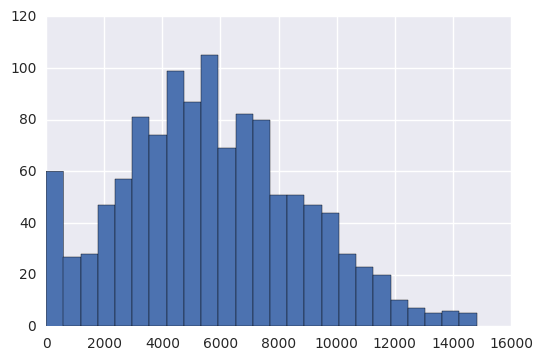

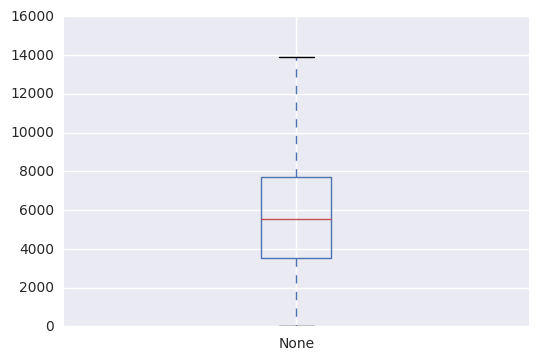

In [191]:
plotDegreeDistribution(G, 'frequency')

#### Degree Distribution and Age

In [15]:
def addAttributesToNodes(g, start_dt):
    aa = ht.get_all_bees_age(start_dt)
    df = DataFrame([int(x) for x in list(g.nodes())], columns=['id'])
    df["age"] = df.id.apply(lambda x: aa.iloc[x].age)
    
    #degree unweighted
    deg = nx.degree(g)
    df['degree'] = df.id.apply(lambda x: deg.get(str(x)))
    #degree weighted - frequency and duration
    degF = nx.degree(g, weight='frequency')
    df['degreeF'] = df.id.apply(lambda x: degF.get(str(x)))
    #degD = nx.degree(g, weight='totalDuration')
    #df['degreeD'] = df.id.apply(lambda x: degD.get(str(x)))
    
    #cc
    clust = nx.clustering(g)
    df['lcc'] = df.id.apply(lambda x: clust.get(str(x)))
    clustF = nx.clustering(g, weight='frequency')
    df['lccF'] = df.id.apply(lambda x: clustF.get(str(x)))
    #clustD = nx.clustering(g, weight='totalDuration')
    #df['lccD'] = df.id.apply(lambda x: clustD.get(str(x)))
    
    # Betweenness Centrality
    between = nx.betweenness_centrality(g)
    df['between'] = df.id.apply(lambda x: between.get(str(x)))
    betweenF = nx.betweenness_centrality(g, weight='frequency')
    df['betweenF'] = df.id.apply(lambda x: betweenF.get(str(x)))
    #betweenD = nx.betweenness_centrality(g, weight='totalDuration')
    #df['betweenD'] = df.id.apply(lambda x: betweenD.get(str(x)))
    
    # Closeness Centrality
    closeness = nx.closeness.closeness_centrality(g)
    df['closeness'] = df.id.apply(lambda x: closeness.get(str(x)))
    closenessF = nx.closeness.closeness_centrality(g, distance='frequency')
    df['closenessF'] = df.id.apply(lambda x: closenessF.get(str(x)))
    #closenessD = nx.closeness.closeness_centrality(g, distance='totalDuration')
    #df['closenessD'] = df.id.apply(lambda x: closenessD.get(str(x)))

    return df

In [ ]:
attributes = addAttributesToNodes(G, start_dt)

In [200]:
def scatterPlot(df, x, y):
    df.plot.scatter(x=x, y=y, s=8, alpha=0.5)
    plt.figure()
    df.plot.scatter(x=x, y=y, s=8, alpha=0.2, xlim=(-30,55))
    plt.figure()
    #df.plot.hexbin(x=x, y=y, xlim=(-20,40), gridsize=80, cmap='winter' )

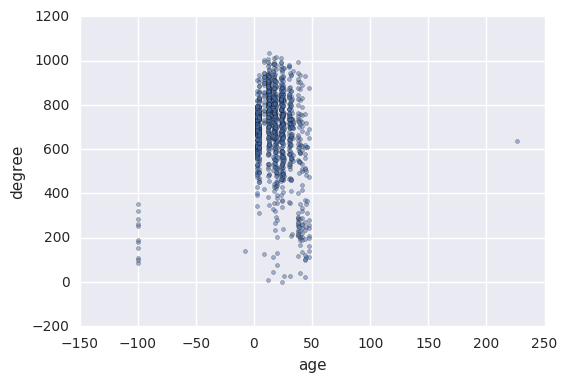

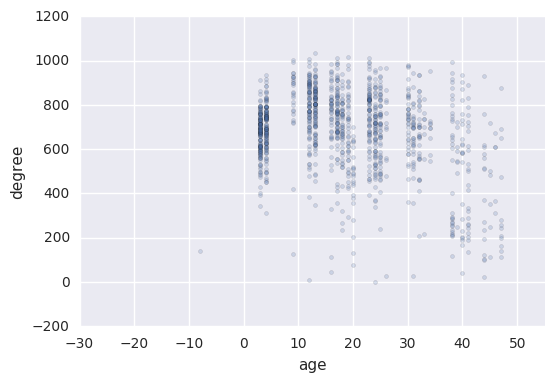

In [201]:
scatterPlot(attributes, 'age', 'degree')

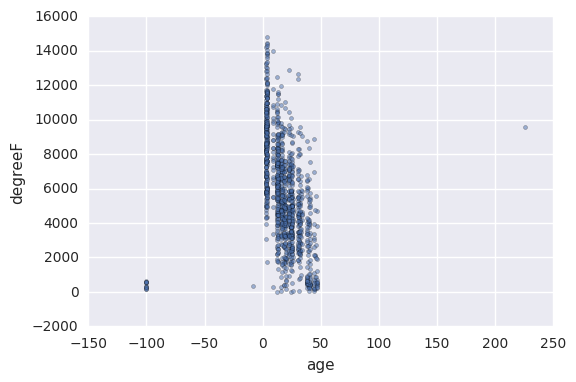

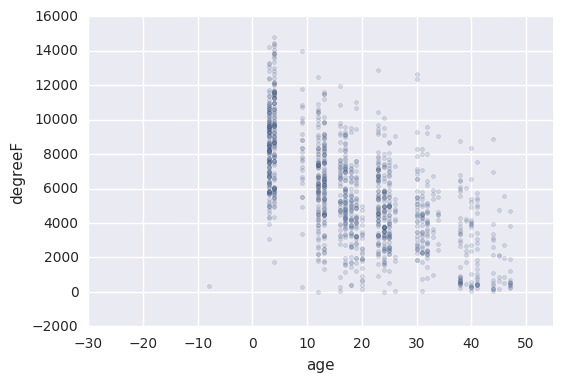

In [202]:
scatterPlot(attributes, 'age', 'degreeF')

### Edges

#### Edge weights distribution

In [203]:
def plotEdgeWeightDistribution(g, w):    
    l = []
    for e in g.edges():
        l.append(g.get_edge_data(e[0],e[1]).get(w))
    edge_weights = Series(l)
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    edge_weights.hist(bins=100)
    print(edge_weights.describe())

count    406023.000000
mean          8.435461
std          12.802688
min           1.000000
25%           2.000000
50%           4.000000
75%          10.000000
max         347.000000
dtype: float64


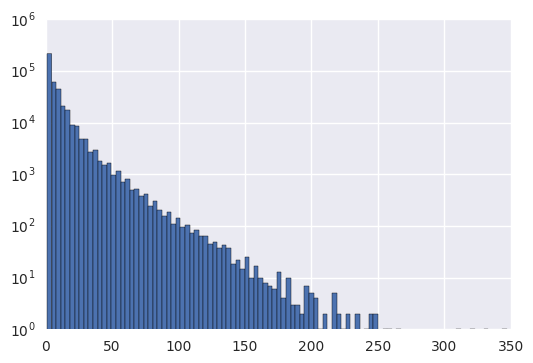

In [204]:
plotEdgeWeightDistribution(G, 'frequency')

count    406023.000000
mean         82.122008
std         186.505312
min           3.000000
25%          10.000000
50%          29.000000
75%          78.000000
max        8357.000000
dtype: float64


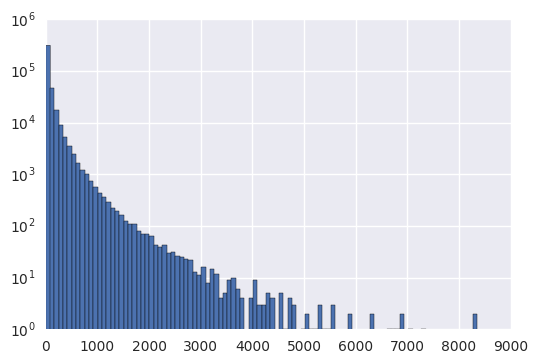

In [205]:
plotEdgeWeightDistribution(G, 'totalduration')

#### Relation Frequency and Duration

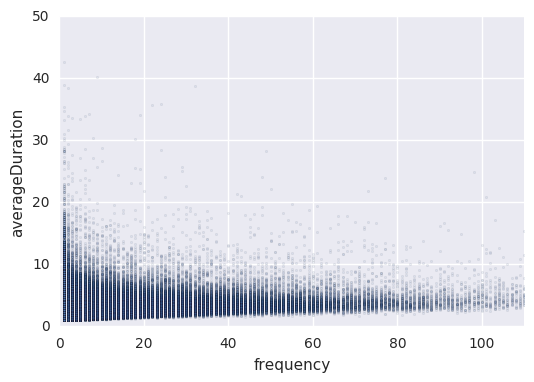

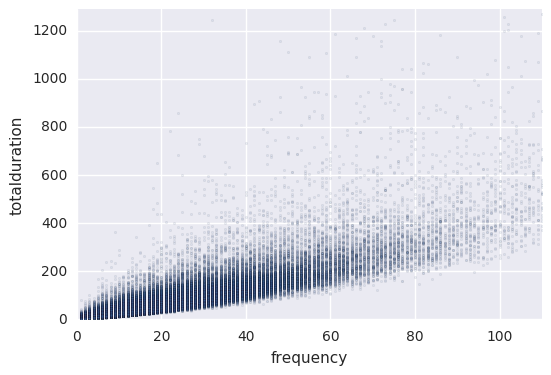

In [206]:
l = []
for e in G.edges():
    f = G.get_edge_data(e[0],e[1]).get('frequency')
    d = G.get_edge_data(e[0],e[1]).get('totalduration')
    
    l.append((f, d/3, d/f/3))
weights = DataFrame(l, columns=['frequency', 'totalduration', 'averageDuration'])
weights.plot.scatter(x='frequency', y='averageDuration', s=3, alpha=0.1, xlim=(0,110), ylim=(0,50))
plt.figure()
weights.plot.scatter(x='frequency', y='totalduration', s=3, alpha=0.1, xlim=(0,110), ylim=(0,1288))

#### Relation Edges and Ages

In [207]:
l = []
for e in G.edges():
    n1 = e[0]
    n2 = e[1]
    
    l.append((n1,n2))
    
weights = DataFrame(l, columns=['n1', 'n2'])
aa = ht.get_all_bees_age(start_dt)
weights['age1'] = weights.n1.apply(lambda x: aa.iloc[int(x)].age)
weights['age2'] = weights.n2.apply(lambda x: aa.iloc[int(x)].age)

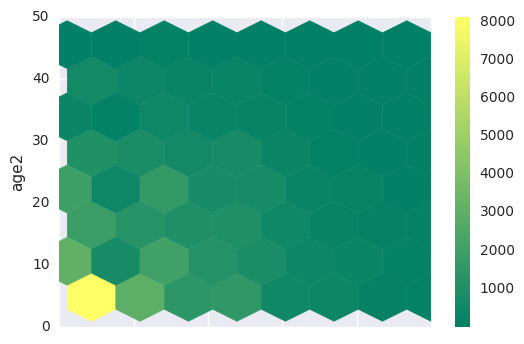

In [217]:
agePairs = Series(list(zip(weights.age1, weights.age2)))
agePairsDF = DataFrame(agePairs.value_counts(), columns=['frequency']).reset_index().rename(columns={'index':'agePair'})
#agePairsDF.frequency = np.log(agePairsDF.frequency)
a = agePairsDF.agePair.apply(pd.Series).rename(columns={0:'age1', 1: 'age2'})
agePairsDF = pd.concat([agePairsDF,a], axis=1)
agePairsDF.plot.hexbin(x='age1', y='age2', C='frequency', xlim=(0,50), ylim=(0,50), gridsize=50, cmap='summer')

#### Age Difference between pair of nodes

In [209]:
ww = weights.query('age1 >= 0 & age1 < 200 & age2 >=0 & age2 < 200')

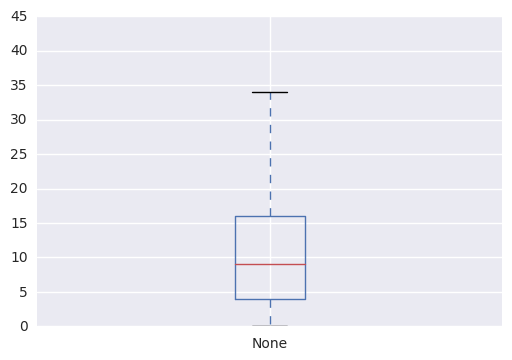

In [210]:
abs(ww.age1-ww.age2).plot.box()

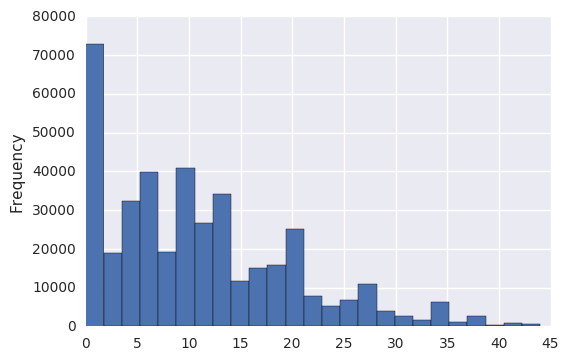

In [211]:
abs(ww.age1-ww.age2).plot.hist(bins=25)

### Disparity

In [218]:
import pythonbackbonenetwork.backbone as bb

I determined whether each ant displayed a homogeneous pattern of associations with its nestmates by calculating its disparity (Barthélemy et al. 2005). The disparity of individual i is defined as: Y2ðiÞ 1⁄4 ij
where Si is the strength of ant i, wij is the weight of association between ants i and j and wðiÞ denotes the set of neighbours of ant i. Low values of disparity indicated that the weights of associa- tions were of the same order and, consequently, that ants inter- acted homogeneously with all nestmates. In contrast, privileged associations between ants were evidenced by relatively large values of disparity showing the dominance of a few weights over the others.

In [219]:
disp = bb.disparity_filter(G, weight="frequency")

In [220]:
nx.info(disp)

'Name: \nType: Graph\nNumber of nodes: 1193\nNumber of edges: 406023\nAverage degree: 680.6756'

count    406023.000000
mean          0.528137
std           0.284211
min           0.000000
25%           0.288400
50%           0.571700
75%           0.787300
max           0.958600
dtype: float64


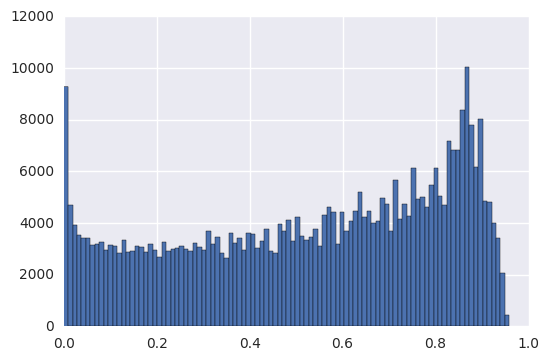

In [221]:
l = []
for e in disp.edges():
    l.append(disp.get_edge_data(e[0],e[1]).get("alpha"))
edge_weights = Series(l)
fig, ax = plt.subplots()
#ax.set_yscale('log')
edge_weights.hist(bins=100)
print(edge_weights.describe())

### Number of components and size distribution

In [222]:
Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
print("Number of components: {}".format(len(Gcc)))

size_components = []
for comp in Gcc:
    size_components.append(nx.number_of_nodes(comp))
    
Counter(list(size_components))

Number of components: 1


Counter({1193: 1})

In [223]:
# keepthe biggest Component
G = Gcc[0]

There is one big component!

### Clustering coefficient

#### Unweighted and weighted average CC

In [51]:
cc = nx.average_clustering(G)
print("Unweighted: {}".format(cc))

Unweighted: 0.636247559125203


In [52]:
cc = nx.average_clustering(G, weight='frequency')
print("Weighted Frequency: {}".format(cc))

Weighted Frequency: 0.005171511506606065


#### Unweighted and weighted local cc

In [224]:
lcc = attributes

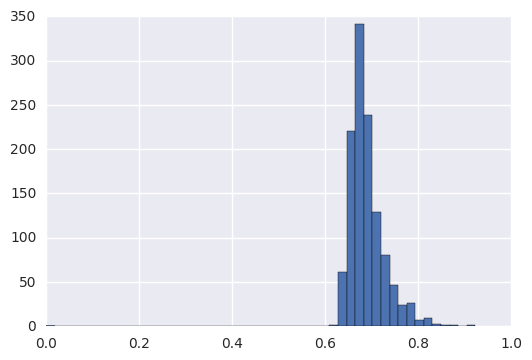

In [225]:
lcc.lcc.hist(bins=50)

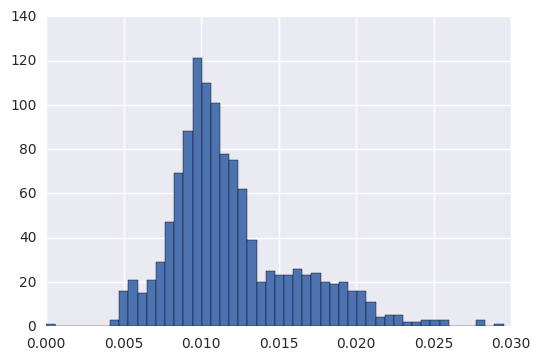

In [226]:
lcc.lccF.hist(bins=50)

#### Local CC and Age

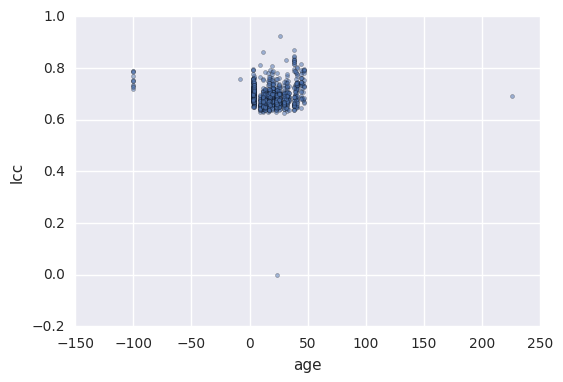

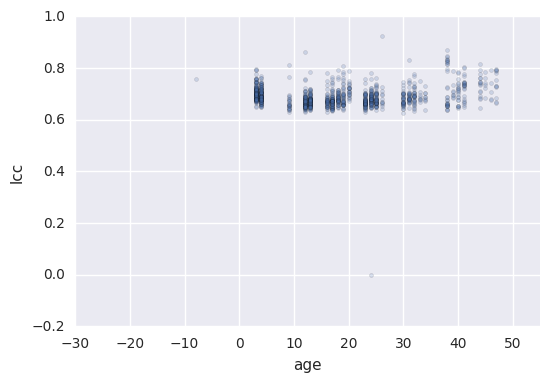

In [227]:
scatterPlot(lcc,'age', 'lcc')

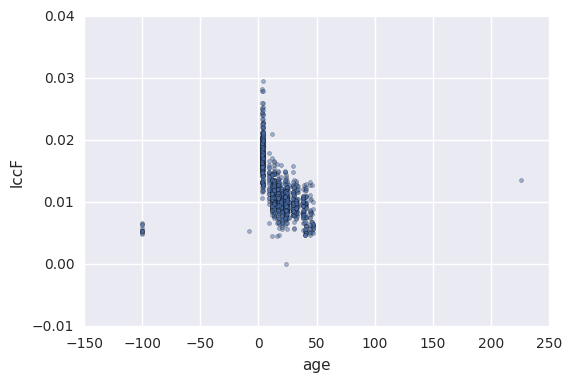

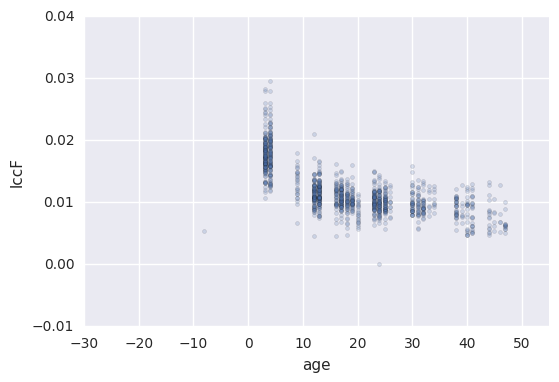

In [228]:
scatterPlot(lcc,'age', 'lccF')

### Average shortest path length (unweighted)

In [64]:
average_shortest_path = nx.average_shortest_path_length(G)
print("Average shortest path: {}".format(average_shortest_path))

Average shortest path: 1.4726292840931408


## Compare to Random Graph Model
* degree distribution (not biniminal/poisson) - ja sieht nicht binominalverteilt aus, sieht ziemlich nach scale free, wenige hubs, viele knote mit wenig links
* connectedness (giant component) - ja sieht ziemlich verbunden aus alles, gibt nur eine große komponente
* average path length (~diameter) - ist hier auch ziemlich klein, Small-world phenomenon, $d = \frac{\ln nodes}{\ln av degree}$
* clustering coefficient - müsste höher sein als bei einem random network, jep ist es auch

In [156]:
random_g = nx.erdos_renyi_graph(n=nx.number_of_nodes(G), p=density)
print(nx.info(random_g))

Name: gnp_random_graph(987,0.19488235499629053)
Type: Graph
Number of nodes: 987
Number of edges: 95197
Average degree: 192.9017


In [157]:
nx.average_clustering(random_g)

0.19563334569818736

In [158]:
nx.average_clustering(G)

0.3462329657137572

## Local Structure (node level metrics)

### Betweenness Centrality (unweighted and weighted)

In [229]:
dfC = attributes

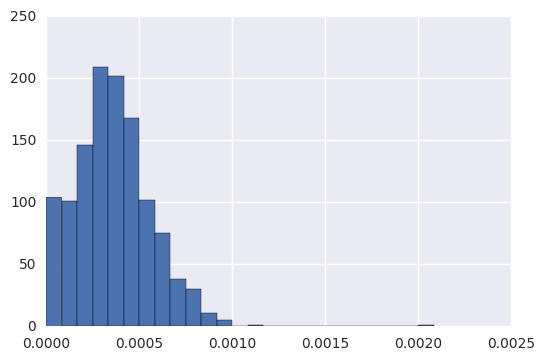

In [230]:
dfC.between.hist(bins=25)

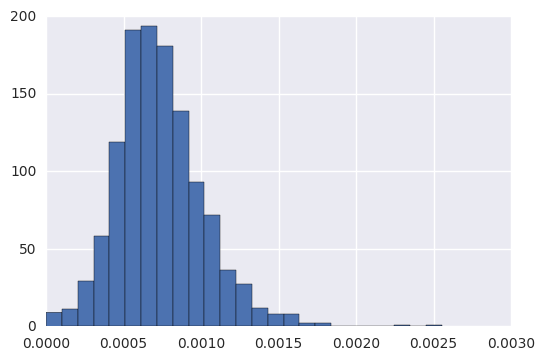

In [231]:
dfC.betweenF.hist(bins=25)

### Betweenness and Age

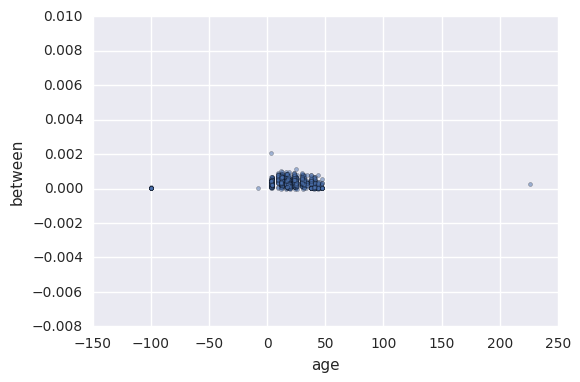

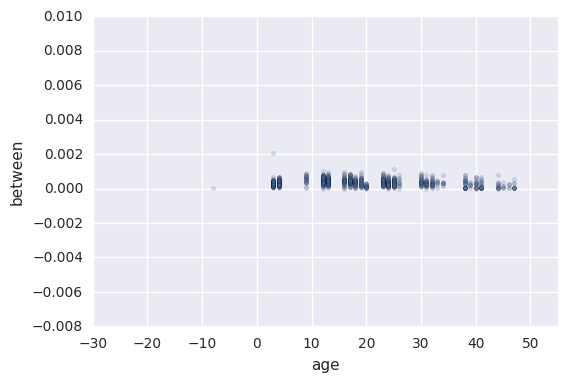

In [232]:
scatterPlot(dfC, 'age', 'between')

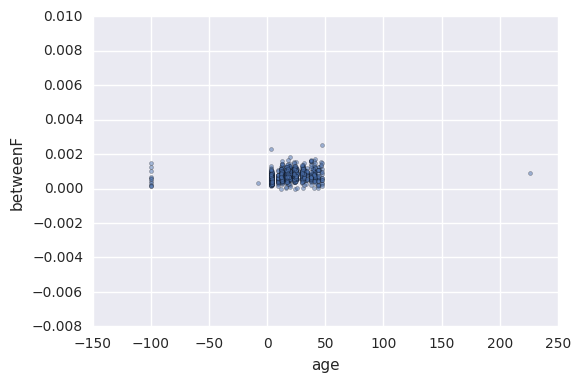

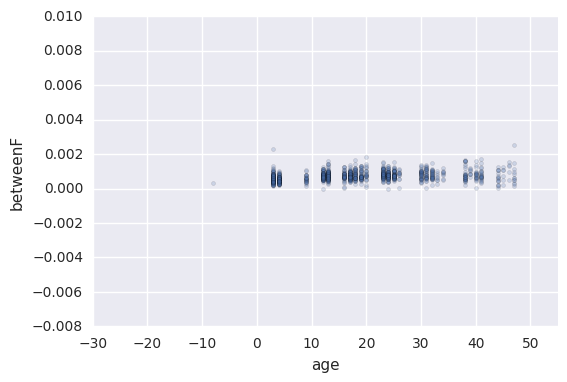

In [233]:
scatterPlot(dfC, 'age', 'betweenF')

### Closeness Centrality (weighted and unweighted)

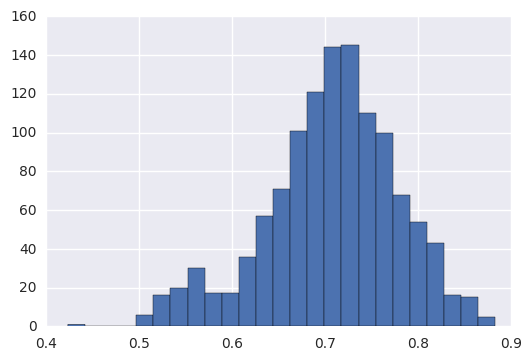

In [234]:
dfC.closeness.hist(bins=25)

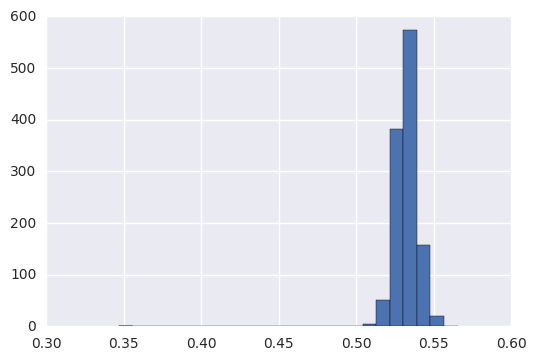

In [235]:
dfC.closenessF.hist(bins=25)

### Closeness and Age

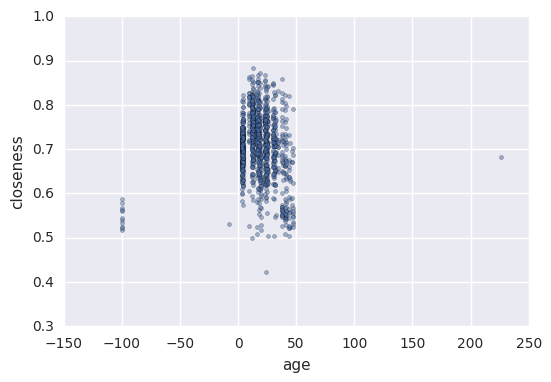

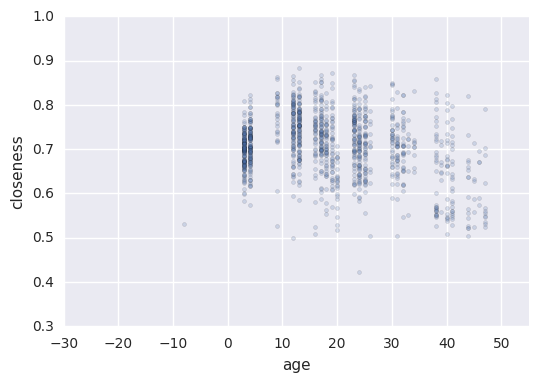

In [236]:
scatterPlot(dfC,"age", "closeness")

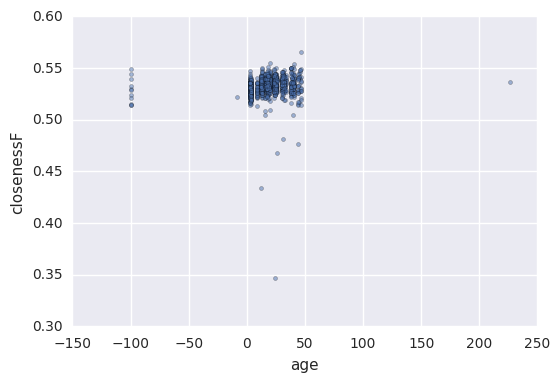

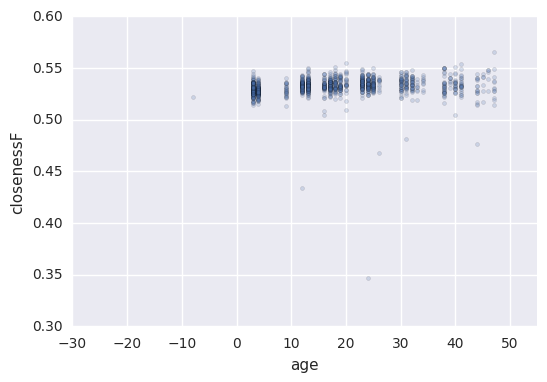

In [237]:
scatterPlot(dfC,"age", "closenessF")

### Eigenvector Centrality

In [80]:
evc = nx.centrality.eigenvector_centrality_numpy(G, weight=None)
dfC['evc'] = dfC.id.apply(lambda x: evc.get(str(x)))

In [76]:
evcF = nx.centrality.eigenvector_centrality_numpy(G, weight="frequency")
dfC['evcF'] = dfC.id.apply(lambda x: evcF.get(str(x)))

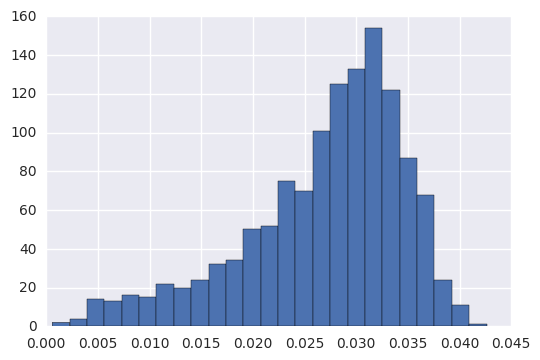

In [81]:
dfC.evc.hist(bins=25)

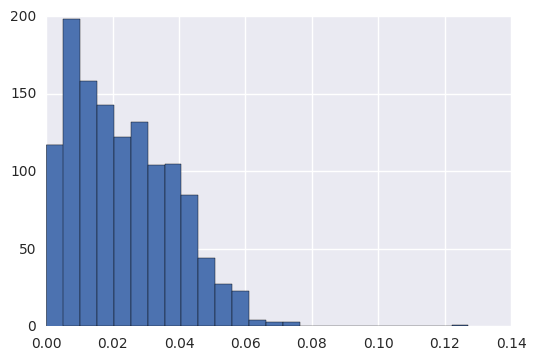

In [77]:
dfC.evcF.hist(bins=25)

# Community Detection

In [238]:
def getCommunitiesFastGreedy(g, limit, w):

    fg = g.community_fastgreedy(weights=w)
    vc = fg.as_clustering(fg.optimal_count)

    # keep communities with lots of members
    cl = [(e,s) for e,s in enumerate(vc.sizes()) if s > limit]

    print(cl)

    a,b = zip(*cl)

    a = list(a)
    b = list(b)

    membership = vc.membership
    print(vc.summary())

    ids = []
    id_list = [[] for i in range(len(vc.sizes()))]

    for name, membership in zip(g.vs, membership):
        ids.append((int(name['id']), membership))
        
        if membership in a:
            id_list[membership].append(int(name['id']))
            
    id_list = [i for i in id_list if (len(i) > limit)]    

    ids = DataFrame(ids, columns=["id", "community"])
    ids = addAge(ids, start_dt)

    return id_list, ids

In [239]:
def getCommunitiesWalktrap(g, limit, w):

    fg = g.community_walktrap(weights=w)
    vc = fg.as_clustering(fg.optimal_count)

    # keep communities with lots of members
    cl = [(e,s) for e,s in enumerate(vc.sizes()) if s > limit]

    print(cl)

    a,b = zip(*cl)

    a = list(a)
    b = list(b)

    membership = vc.membership
    print(vc.summary())

    ids = []
    id_list = [[] for i in range(len(vc.sizes()))]

    for name, membership in zip(g.vs, membership):
        ids.append((int(name['id']), membership))
        
        if membership in a:
            id_list[membership].append(int(name['id']))
            
    id_list = [i for i in id_list if (len(i) > limit)]    

    ids = DataFrame(ids, columns=["id", "community"])
    ids = addAge(ids, start_dt)

    return id_list, ids

In [240]:
def getDFwithIDSts(ids, begin, end, conn):
    ids_str = ', '.join([str(x) for x in ids])
    sql = '''
        SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
        FROM DETECTIONS d
        INNER JOIN FRAME f
        ON d.FRAME_ID=f.FRAME_ID
        INNER JOIN FRAME_CONTAINER fc
        ON f.FC_ID=fc.FC_ID
        WHERE d.ID IN ({}) AND
        f.TIMESTAMP >= {} AND
        f.TIMESTAMP <= {};
    '''.format(ids_str, begin,end)
    return pd.read_sql(sql, conn)

In [99]:
# input: "2016-07-21T15:00:00Z"
# returns TS
def getTS(string):
    start_dt = datetime.datetime.strptime(string, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
    return start_dt.timestamp()

In [100]:
def plotHeatmapXY(txt, df, camIDleft, camIDright):
    data_l = df[df.CAM_ID == camIDleft]
    data_r = df[df.CAM_ID == camIDright]
    data_r.XPOS = 3000 - data_r.XPOS
    data_r.YPOS = 4000 - data_r.YPOS
    data_r.XPOS = data_r.XPOS + 3000
    data = pd.concat([data_l,data_r])
    x = data.XPOS
    y = data.YPOS

    H, xedges, yedeges, im = plt.hist2d(x,y,bins=[60,40])
    plt.colorbar()
    plt.axes().set_title("{} \nCam {} & Cam {}".format(txt, str(camIDleft), str(camIDright)))
    
    return H

In [245]:
g = ig.Graph.Read_GraphML(f)

## FastGreedy

In [246]:
id_listN, df_idsN = getCommunitiesFastGreedy(g, 0, None)

[(0, 608), (1, 583), (2, 2)]
Clustering with 1193 elements and 3 clusters


In [247]:
id_listF, df_idsF = getCommunitiesFastGreedy(g, 0, 'frequency')

[(0, 359), (1, 834)]
Clustering with 1193 elements and 2 clusters


## XY Positions per Group (unweighted)

In [119]:
db_path = "/mnt/data/2016_07_30_10h_8Uhr_95conf.db"
conn = sqlite3.connect(db_path)

In [124]:
1751 in set(id_listF[0])

True

In [125]:
def positions(comm, ids, conn):
    df = getDFwithIDSts(ids, getTS('2016-07-30T08:00:00Z'), getTS('2016-07-26T18:00:00Z'), conn)
    plotHeatmapXY('Community {} (n={})'.format(comm,len(ids)), df, 2,3)
    plt.figure()
    plotHeatmapXY('Community {} (n={})'.format(comm,len(ids)), df, 1,2)
    plt.figure()

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


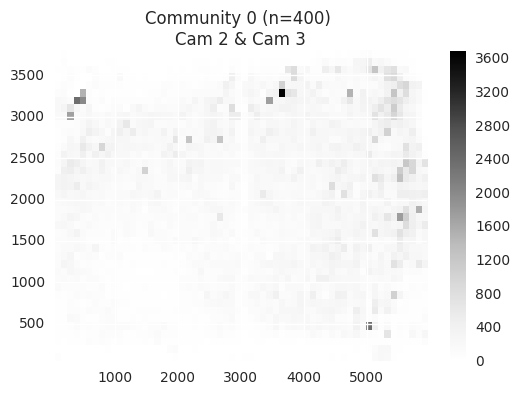

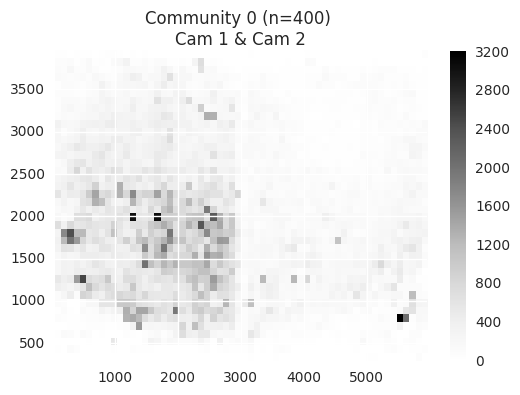

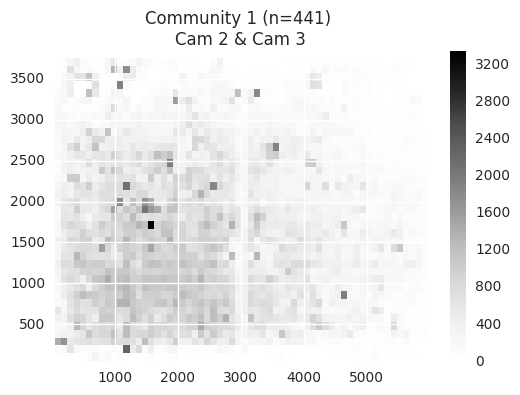

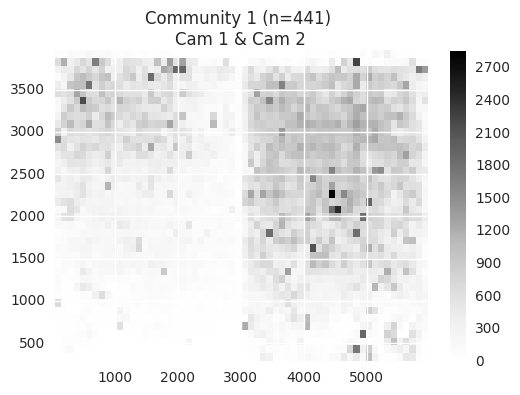

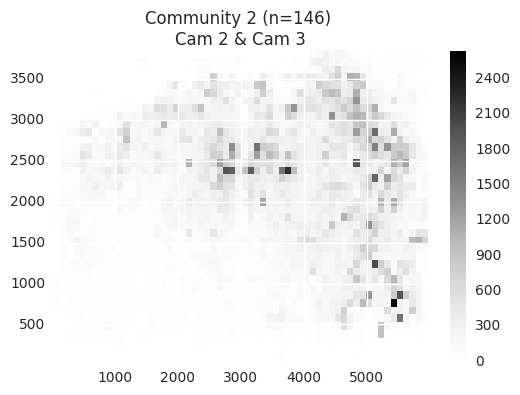

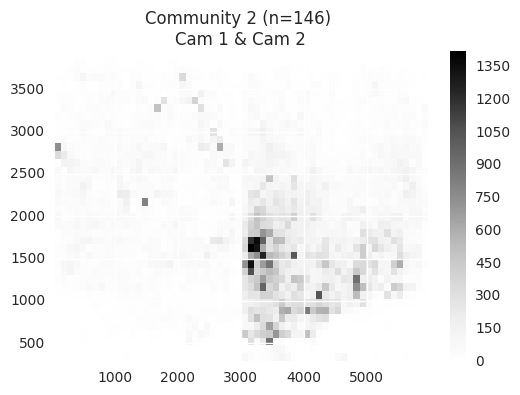

In [484]:
for e, l in enumerate(id_listN):
    positions(e, l, conn)

## XY Positions weighted frequency

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


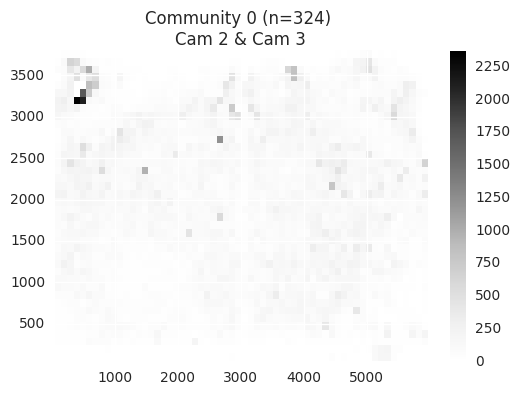

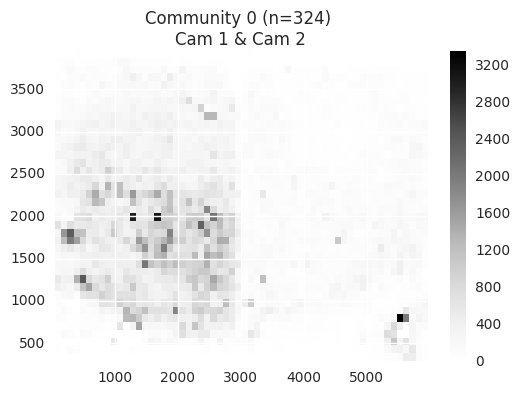

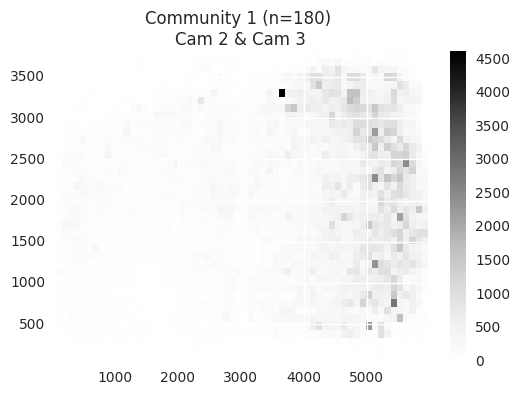

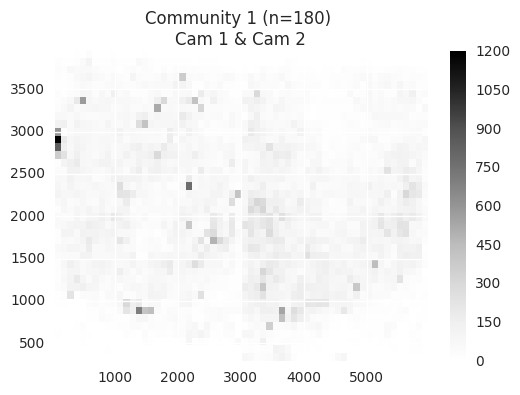

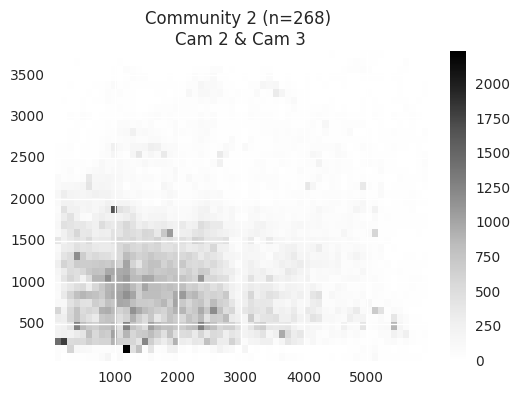

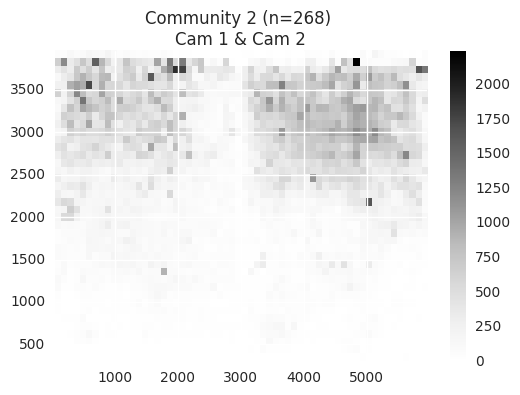

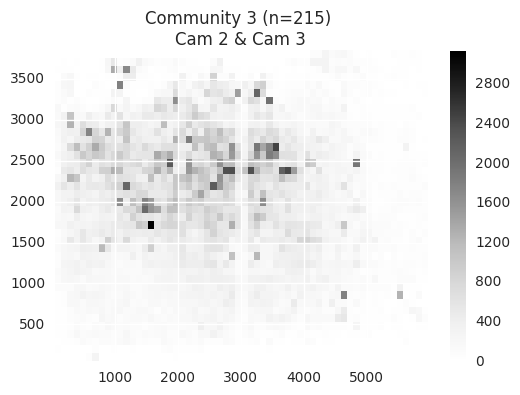

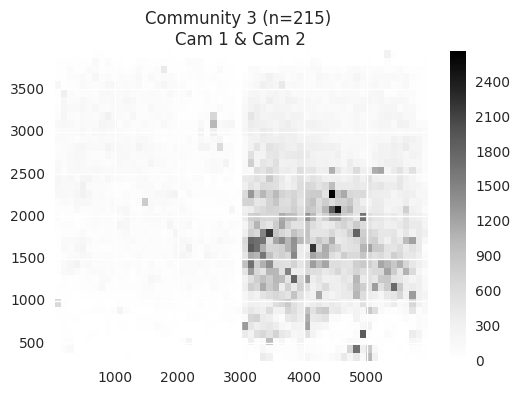

In [482]:
for e, l in enumerate(id_listF):
    positions(e, l, conn)

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


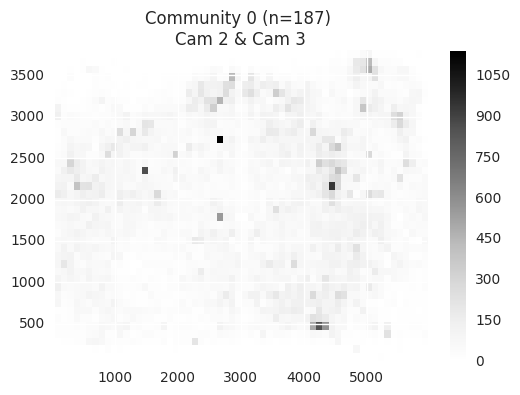

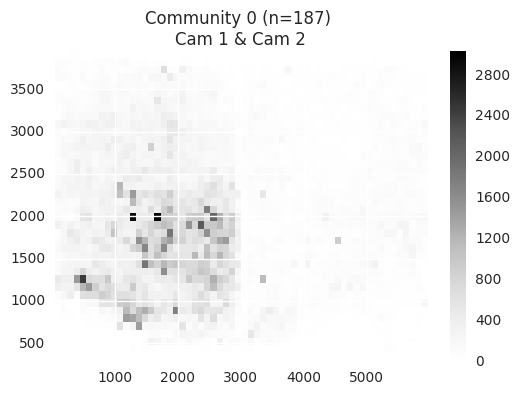

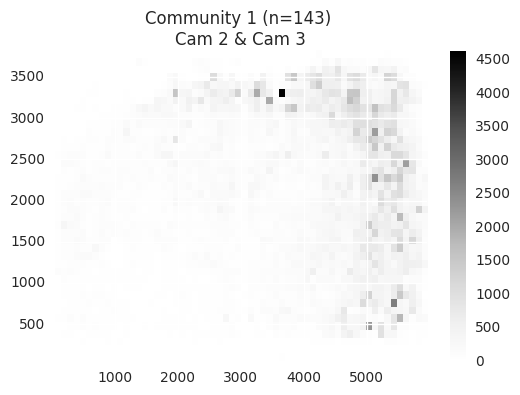

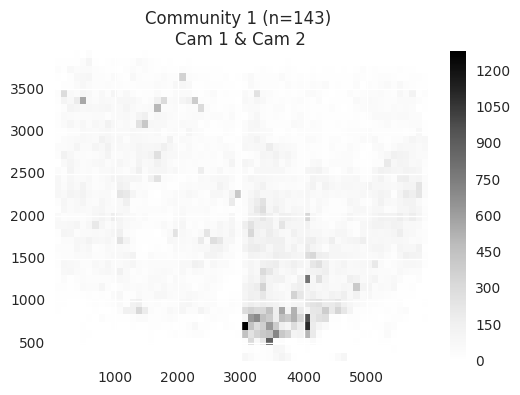

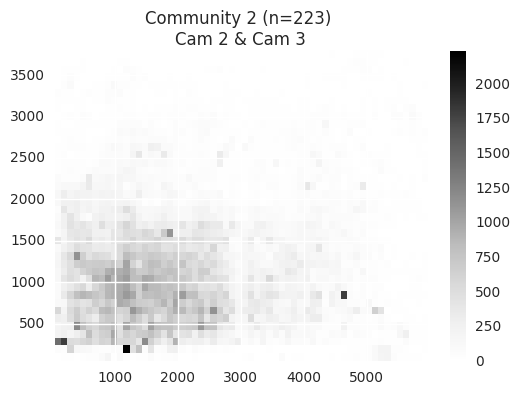

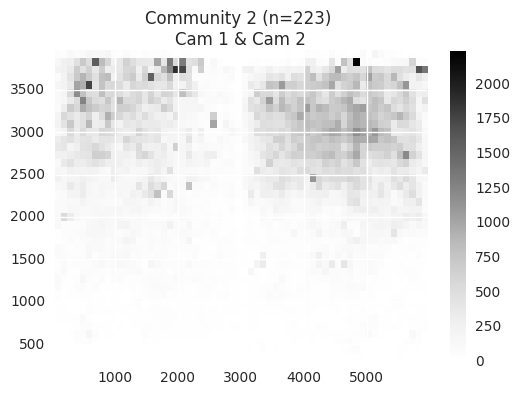

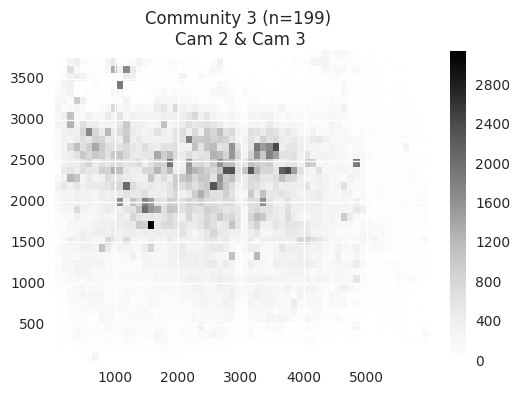

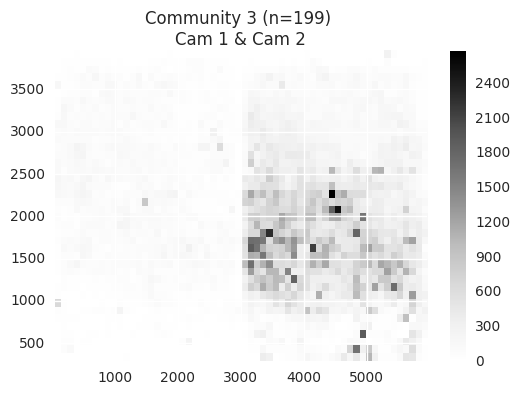

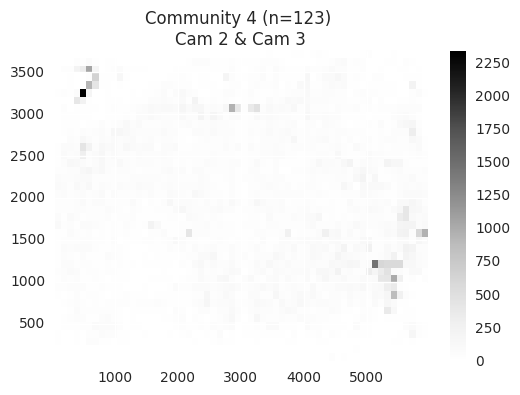

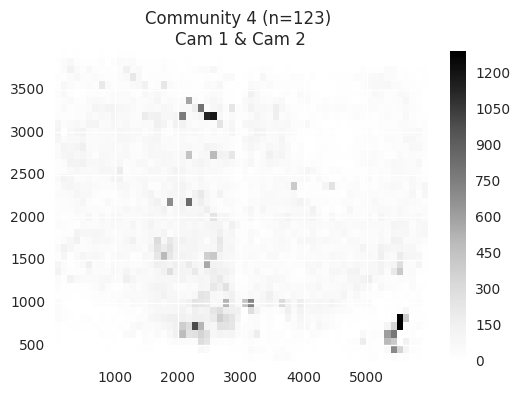

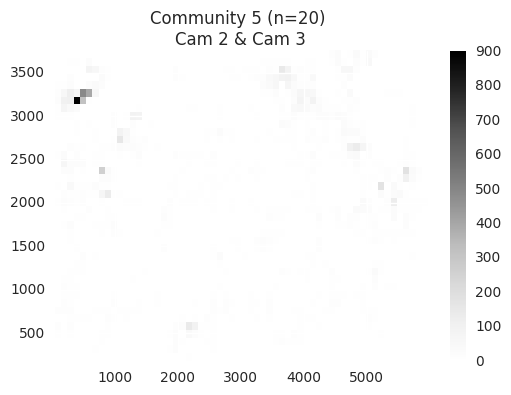

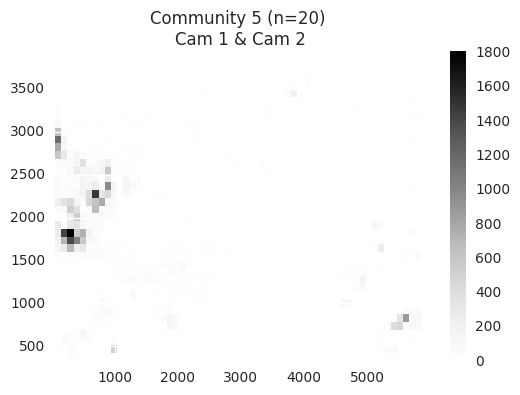

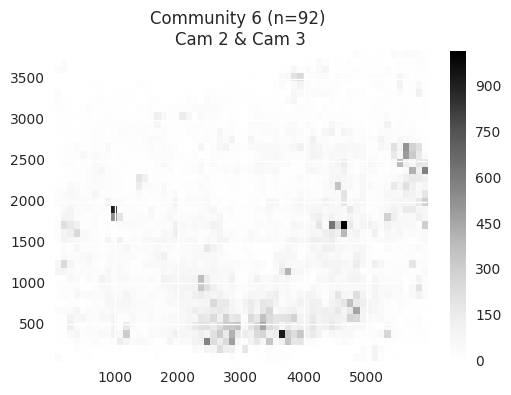

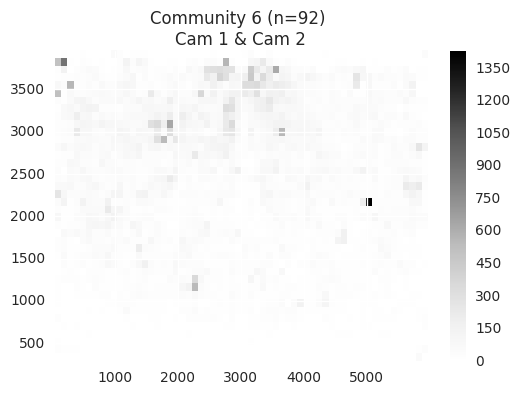

In [483]:
for e, l in enumerate(id_listD):
    positions(e, l, conn)

## Age per Group

In [115]:
def kolmogorovStest(df):
    gr = df.groupby(by="community")
    for g1, gr1 in gr:
        for g2, gr2 in gr:
            if g1>=g2:
                continue
            print(g1, g2,stats.ks_2samp(df.age[df.community == g1], df.age[df.community == g2]))

In [112]:
def AgePerGroup(df):
    print("Total Mean: {}".format(df.age.mean()))
    
    df = df.query("age > -100 & age < 200")
    print("Mean after removal over very high and low: {}".format(df.age.mean()))

    df.age.hist(by=df.community, bins=15)
    
    print("\nMean by community:")
    print(df.groupby(by="community").age.mean())

### unweighted

Total Mean: 10.970055161544524
Mean after removal over very high and low: 12.049441786283891

Mean by community:
community
0     6.974026
1    18.458182
2    11.363636
Name: age, dtype: float64


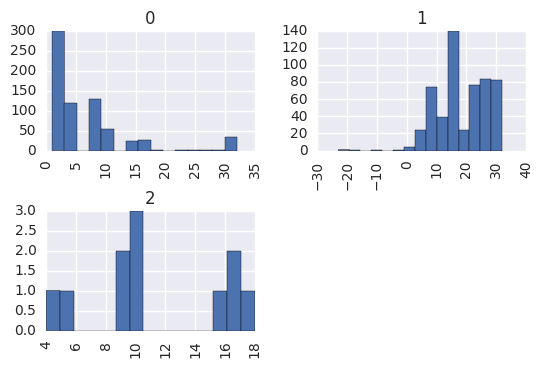

In [113]:
AgePerGroup(df_idsN)

In [116]:
kolmogorovStest(df_idsN)

0 1 Ks_2sampResult(statistic=0.61398396546407652, pvalue=2.9395846006648415e-103)
0 2 Ks_2sampResult(statistic=0.46205673758865251, pvalue=0.0082229193021116885)
1 2 Ks_2sampResult(statistic=0.46014492753623193, pvalue=0.0088124359424596992)


### weighted Frequency

Total Mean: 10.970055161544524
Mean after removal over very high and low: 12.049441786283891

Mean by community:
community
0     5.644796
1    17.938163
2    10.008130
Name: age, dtype: float64


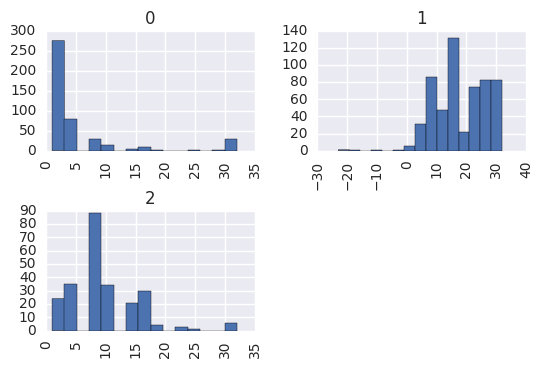

In [117]:
AgePerGroup(df_idsF)

In [118]:
kolmogorovStest(df_idsF)

0 1 Ks_2sampResult(statistic=0.73552028218694887, pvalue=3.261713603014241e-120)
0 2 Ks_2sampResult(statistic=0.57238095238095232, pvalue=2.4955081767014044e-47)
1 2 Ks_2sampResult(statistic=0.45987654320987659, pvalue=4.2423119656910912e-33)
